In [1]:
import os 
from pathlib import Path
import math
import numpy as np
from tqdm.notebook import tqdm
import rasterio 
from fastai.vision.all import *
import albumentations as A

In [2]:
#  this path should contain folders of images of each class
path = Path('/media/nick/2TB Working 3/Projects/Dunes/1000px/multiband/Training data')
# make new folder for models within the training data folder
model_path = os.path.join(path,'models')
Path(model_path).mkdir(parents=True, exist_ok=True)

In [3]:
# set image size
img_size = 1000
# set batch size
bs = 5

In [4]:
# open an image and convert it to a tensor
def open_img(path):
#     use rasterio to open image as numpy array and rescale to 0-1
#     you may need to change this if you have values above 255
    img_as_array = rasterio.open(path).read().astype('float32')/255.0
#     convert numpy array to tensor
    img_as_tensor = torch.from_numpy(img_as_array)
#     resize tensor if necessary
    img_as_tensor_res = resize_tensor(img_as_tensor)
    return img_as_tensor_res

# resize the dimensions of a tensor
def resize_tensor(input_tensor):
#     from https://stackoverflow.com/questions/59803041/resize-rgb-tensor-pytorch
    tensor_un = input_tensor.unsqueeze(0)
    tensor_res = torch.nn.functional.interpolate(tensor_un,size=(img_size,img_size), mode='bilinear', align_corners=True)
    tensor_sq = tensor_res.squeeze(0)
    return(tensor_sq)

# get the image label from the folder name
def get_label(path):
    label = os.path.basename(os.path.dirname(path))
    return label 
 
# open 3 consecutive channels of a tensor as an image
def show_tensor(tensor, first_channel = 0):
    plt.imshow(tensor[0+first_channel:3+first_channel].permute(1, 2, 0).numpy())
    
# open image as a tensor then open 3 consecutive channels as an image
def show_tensor_from_path(path, first_channel = 0):
    tensor = open_img(path)
    show_tensor(tensor,first_channel)

# convert 3 consecutive channels of a tensor to numpy array 
def tensor_to_np_3b(tensor, first_channel = 0):
    return tensor[0+first_channel:3+first_channel].permute(1, 2, 0).numpy()

In [5]:
# grab all tif files in 'path'
all_images = get_files(path, extensions='.TIF')
print(len(all_images),'images')
print(all_images[0])

4540 images
/media/nick/2TB Working 3/Projects/Dunes/1000px/multiband/Training data/Coastal dunes/6_band455_412_VIVID_Landgate_20190910_112120211113.tif


Coastal dunes
torch.Size([6, 1000, 1000])


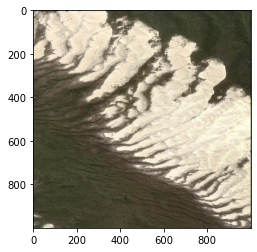

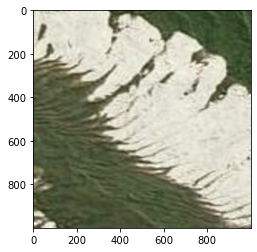

In [6]:
# try opening an image and displaying channels 0,1,2 anf 3,4,5
img_num = 2
print(get_label(all_images[img_num]))

input_image = open_img(all_images[img_num])
print(input_image.size())

img = show_tensor(input_image,first_channel=0)
plt.figure()
img = show_tensor(input_image,first_channel=3)

In [7]:
# we can't use the built in fastai augmentations as they expect 3 channel images so we are using Albumentations instead
# https://github.com/albumentations-team/albumentations
# add as many as you want but these are executed on CPU so can be slow...
transform_list = [A.RandomBrightnessContrast(p=1,brightness_limit=.2),
                  A.RandomRotate90(p=0.5),
                  A.HorizontalFlip(p=.5),
                  A.VerticalFlip(p=.5),
                  A.Blur(p=.1),
                  A.Rotate(p=0.5,limit = 10)
                 ]

In [8]:
# apply the augmentations in a loop
def aug_tfm(tensor):
#     this function is used for both images and labels so check the count of the input tensor
#     if the count is above 1 its not a label so apply the augmentations
    if tensor.nelement()>1:
#         convert tensor into numpy array and reshape it for Albumentations
        np_array = np.array(tensor.permute(1,2,0))
#        apply each augmentation
        for transform in transform_list:
            np_array = transform(image=np_array)['image']
#         some augmentations may shift the values outside of 0-1 so clip them  
        np_array = np.clip(np_array, 0, 1)
#        rearrange image to tensor format
        array_arange = np_array.transpose(2,0,1)
#        convert back to tensor
        tensor = torch.from_numpy(array_arange)

    return tensor

In [9]:
# using RandTransform applies the augmentations to the traning dat but not validation data
multi_tfm = RandTransform(enc=aug_tfm, p=1)

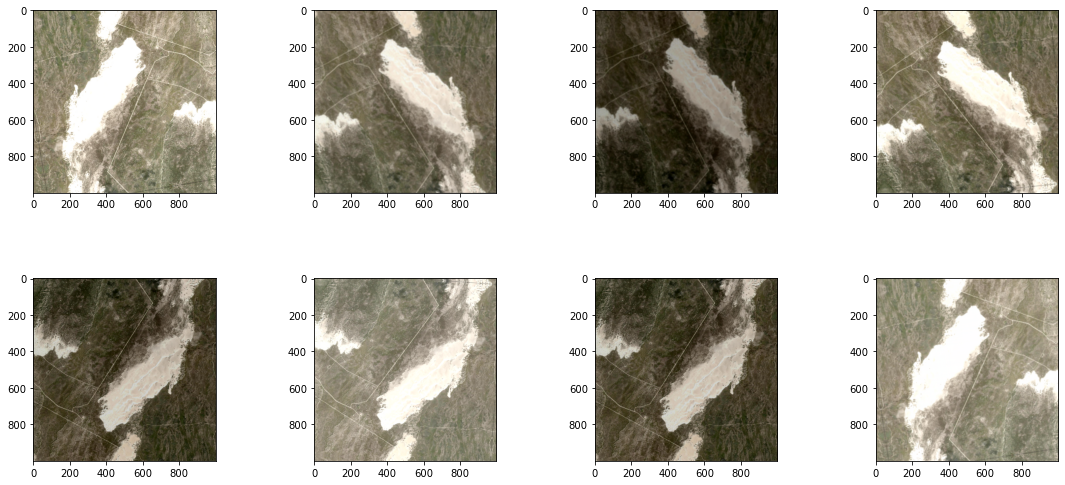

In [10]:
# try out aug_tfm
aug_test = open_img(all_images[1])

rows = 2
cols = 4

axes=[]
fig=plt.figure()

for a in range(rows*cols):
    b = tensor_to_np_3b(aug_tfm(aug_test))
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(b)
fig.tight_layout() 
fig.set_size_inches(cols*4, rows*4)
plt.show()

In [11]:
# setup datablock and dataloader
db = DataBlock(blocks=(TransformBlock(open_img), CategoryBlock),
                   get_items = get_image_files,
               get_y= get_label,
               splitter=RandomSplitter(valid_pct=0.2, seed=42),
               item_tfms=multi_tfm,
                             )
dl = db.dataloaders(source=path, bs=bs)
batch = dl.one_batch()
print(batch[0].shape, batch[1])

torch.Size([5, 6, 1000, 1000]) TensorCategory([1, 1, 2, 2, 1], device='cuda:0')


In [12]:
channel_count= batch[0].shape[1]
print('Channel count =',channel_count)

Channel count = 6


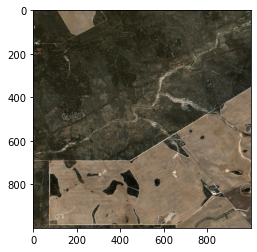

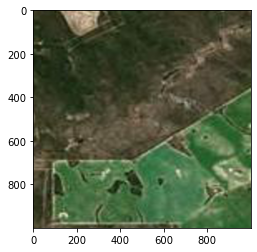

In [13]:
# grab a validation tensor, place it on the cpu then show it, this should not have augmentations
# first image is channels 0,1,2 second is 3,4,5
valid_tensor = dl.valid.one_batch()[0][0].cpu()

show_tensor(valid_tensor, first_channel =0)
plt.figure()
show_tensor(valid_tensor, first_channel =3)

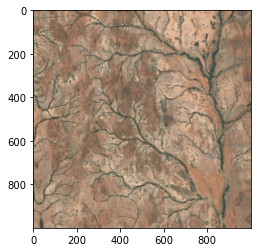

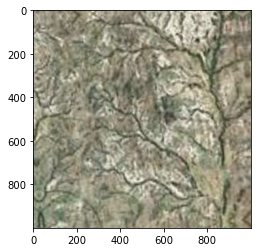

In [18]:
# show one tensor from training set with augmentations
# first image is channels 0,1,2 second is 3,4,5
train_tensor = dl.train.one_batch()[0][0].cpu()

show_tensor(train_tensor,first_channel =0)
plt.figure()
show_tensor(train_tensor,first_channel =3)

In [19]:
# db.summary(path)

In [20]:
learn = cnn_learner(dl, resnet18, n_in=channel_count, pretrained=True, metrics=error_rate).to_fp16()

In [21]:
# we need to duplicate the RGB weights by an arbitrary count, but we can only increase it by 3 at a time with 'repeat'
# so we work out how many times we need to repeat it, round that number up, repeat the weights that many times
# then chop off any excess.

# grab a reference to the first layer of the model, the layer we need to edit to pull over the pretrained weights
layer1 = learn.model[0][0]
print(layer1)
# access the weights of the layer
l1_weights = layer1.weight
print(l1_weights.shape)

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([64, 6, 7, 7])


In [22]:
pretrained_channel_count = 3

channel_ratio = channel_count/pretrained_channel_count

# define how many times we need to duplicate the weights
repeat_count = math.ceil(channel_ratio)

# duplicate the RGB weights for all additional channels
#           RGB weights       repeat on 2nd axis     chops off any excess 
l1_weights = l1_weights[:,:pretrained_channel_count].repeat(1,repeat_count,1,1)[:,:channel_count]

# rescale weights by channel_ratio
l1_weights = l1_weights / channel_ratio

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=6.309573450380412e-07)

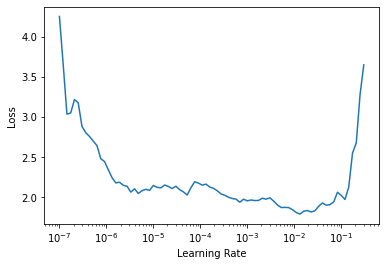

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.802305,0.395677,0.174009,02:48
